<a href="https://colab.research.google.com/github/strz/ITWILL_Citrus-Tea/blob/master/Inception_v3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**파이썬 Inception_v3를 이용한 쯔쯔가무시 등 5종 분류 및 예측**

2020.02.20 (목)
 - 각 클래스당 이미지를 2,000장 부풀려 클래스당 비율을 맞춤.<br>
 (xy_googlenet_1_save.npy: 2,000장 (224,224) 사용)
 - 모델은 Inception_v3의 pretrained model 사용.<br>
 (keras.applications.inception_v3에서 이미 학습된 가중치값을 가져와 학습, 속도가 훨씬 빠름)

**1. 버전 설정 및 확인**

In [1]:
# Tensorflow 사용버전 설정
%tensorflow_version 1.x

# Tensorflow 버전과 GPU 사용 여부 확인
import tensorflow as tf

print(tf.__version__)
print(tf.test.gpu_device_name()) 

1.15.0
/device:GPU:0


In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**2. 클래스 및 모듈 import**

In [3]:
from keras.applications.inception_v3 import InceptionV3

import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Model, Input
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, AveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from keras.engine.saving import load_model
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


**3. dataset 불러오기 & 전처리**

(생략된 부분 - 이미지 부풀리는 과정)

In [4]:
### np.save로 저장된 파일 불러오기
X_train, X_test, y_train, y_test = np.load('./drive/My Drive/final_project/xy_googlenet_1_save.npy', allow_pickle=True)
# xy_googlenet_1_save.npy = 2,000장씩 (224,224,3)

# 정규화 시키기
X_train = X_train.astype('float16') / 255
X_test = X_test.astype('float16') / 255

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')   # X_train: (9144, 224, 224, 3), y_train: (9144, 5)
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')   # X_test: (2287, 224, 224, 3), y_test: (2287, 5)

print(f'X_train: {X_train[0]}, X_test: {X_test[0]}')

X_train: (9144, 224, 224, 3), y_train: (9144, 5)
X_test: (2287, 224, 224, 3), y_test: (2287, 5)
X_train: [[[0.886  0.8115 0.745 ]
  [0.9097 0.8354 0.7686]
  [0.933  0.859  0.792 ]
  ...
  [0.8237 0.643  0.5527]
  [0.8354 0.655  0.5605]
  [0.8706 0.6904 0.596 ]]

 [[0.886  0.8115 0.745 ]
  [0.9097 0.8354 0.7686]
  [0.933  0.859  0.792 ]
  ...
  [0.8237 0.643  0.5527]
  [0.8354 0.655  0.5605]
  [0.8706 0.6904 0.596 ]]

 [[0.89   0.816  0.749 ]
  [0.906  0.8315 0.7646]
  [0.9214 0.847  0.7803]
  ...
  [0.8276 0.647  0.5566]
  [0.8354 0.655  0.5605]
  [0.8667 0.686  0.5923]]

 ...

 [[0.9453 0.8784 0.816 ]
  [0.9414 0.8745 0.8115]
  [0.9414 0.8745 0.8115]
  ...
  [0.89   0.784  0.702 ]
  [0.8823 0.784  0.706 ]
  [0.8706 0.7725 0.6943]]

 [[0.9414 0.8745 0.8115]
  [0.9414 0.8745 0.8115]
  [0.9414 0.8745 0.8115]
  ...
  [0.894  0.788  0.706 ]
  [0.8823 0.784  0.706 ]
  [0.859  0.7607 0.682 ]]

 [[0.9414 0.8745 0.8115]
  [0.9414 0.8745 0.8115]
  [0.9414 0.8745 0.8115]
  ...
  [0.894  0.788  0

**5. 신경망 생성**

In [7]:
# pre_trained model 불러오기
input_shape = (224, 224, 3)
base_model = InceptionV3(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 요약
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

In [8]:
# 컴파일
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# 신경망 모델의 성능 향상이 없는 경우 중간에 epoch을 빨리 중지시키기 위해서
early_stop = EarlyStopping(monitor='val_loss',
                            verbose=1,
                            patience=10)

# 신경망 학습모델 파일로 저장
model_dir = "./drive/My Drive/final_project/"
if not os.path.exists(model_dir):  # model_dir이 없을 경우 폴더 생성
    os.mkdir(model_dir)

model_path = model_dir + '/Inception_v3_2.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 신경망 학습
history = model.fit(X_train, y_train,
                    epochs=50,     # 에폭만큼 파라미터 업데이트
                    batch_size=200,  # 전체갯수를 batch_size로 나눈 만큼 반복
                    callbacks=[checkpoint, early_stop],
                    validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7315 samples, validate on 1829 samples
Epoch 1/100
7315/7315 [==============================] - 67s 9ms/step - loss: 0.4817 - acc: 0.8185 - val_loss: 0.9550 - val_acc: 0.7447

Epoch 00001: val_loss improved from inf to 0.95496, saving model to ./drive/My Drive/final_project//Inception_v3_2.model
Epoch 2/100
7315/7315 [==============================] - 43s 6ms/step - loss: 0.2646 - acc: 0.8962 - val_loss: 0.8957 - val_acc: 0.7419

Epoch 00002: val_loss improved from 0.95496 to 0.89571, saving model to ./drive/My Drive/final_project//Inception_v3_2.model
Epoch 3/100
7315/7315 [==============================] - 42s 6ms/step - loss: 0.2225 - acc: 0.9151 - val_loss: 0.3476 - val_acc: 0.8704

Epoch 00003: val_loss improved from 0.89571 to 0.34762, saving model to ./drive/My Drive/final_project//Inception_v3_2.model
Epoch 4/100
7315/7315 [==============================] - 42s 6ms/step - lo

**6. 신경망 학습 및 평가**

In [14]:
# 테스트 데이터를 사용해서 신경망 모델을 평가
# 테스트 데이터의 Loss, Accuracy
eval = model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]}, accuracy: {eval[1]}')
### 1
# Test loss: 0.922806359721617, accuracy: 0.8117209708250093
### 2
# Test loss: 0.5639182739725371, accuracy: 0.86226497597709
# loss: 0.0298 - acc: 0.9891 - val_loss: 0.6317 - val_acc: 0.8529

### 3
# Test loss: 0.9771581690646073, accuracy: 0.7901180587484162

2287/2287 [==============================] - 5s 2ms/step
Test loss: 0.9771581690646073, accuracy: 0.7901180587484162


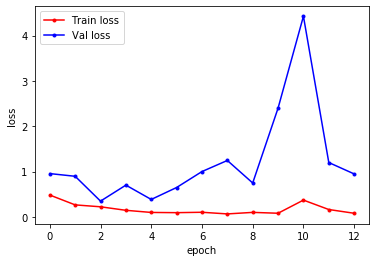

In [15]:
# 학습 데이터와 테스트 데이터의 Loss 그래프
train_loss = history.history['loss']  # history dictionary에 저장된 'loss' 키를 갖는 value들을 가져옴
val_loss = history.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

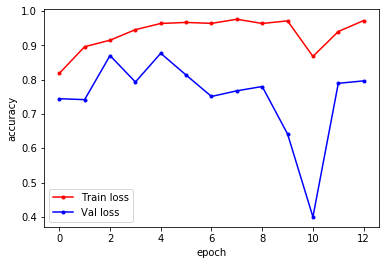

In [16]:
# 학습 데이터, 테스트 데이터의 정확도 그래프
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

x = range(len(train_accuracy))
plt.plot(x, train_accuracy, marker='.', color='red', label='Train loss')
plt.plot(x, val_accuracy, marker='.', color='blue', label='Val loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**7. Confusion matrix**

In [17]:
# # 저장한 학습모델 불러옴.
# model = load_model('./model/Inception_v3_2.model')

categories = ["df", "mel", "nv", "tsu", "vl"]

# confusion matrix & classification report
print(y_test)

y_true = np.argmax(y_test, axis=1)   # 행 중 가장 큰값의 idx
# (one-hot-encoding 되어있으므로 1로 표시된 값을 행에서 가장 큰값으로 출력하여 array로 만듦)
print(y_true)
y_pred = np.argmax(model.predict(X_test), axis=1)
print(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(cm)
# 세로가 실제클래스, 가로가 예측클래스
## 1 
# [[ 420  334   44   33    1]
#  [   1  860   68    1    0]
#  [   1  312  595    2    3]
#  [   1   20    2 1018    3]
#  [   0   13   18    4  819]]

### 2
# [[412   5  23   3   2]
#  [  4 380  58   9   0]
#  [  1  40 393   4   0]
#  [  0   0   0 536   0]
#  [  0   5   2  26 384]]


report = classification_report(y_true, y_pred, target_names=categories)
print(report)
## 1
#               precision    recall  f1-score   support

#           df       0.99      0.50      0.67       832
#          mel       0.56      0.92      0.70       930
#           nv       0.82      0.65      0.73       913
#          tsu       0.96      0.98      0.97      1044
#           vl       0.99      0.96      0.97       854

#     accuracy                           0.81      4573
#    macro avg       0.86      0.80      0.81      4573
# weighted avg       0.86      0.81      0.81      4573

### 2
#               precision    recall  f1-score   support

#           df       0.99      0.93      0.96       445
#          mel       0.88      0.84      0.86       451
#           nv       0.83      0.90      0.86       438
#          tsu       0.93      1.00      0.96       536
#           vl       0.99      0.92      0.96       417

#     accuracy                           0.92      2287
#    macro avg       0.92      0.92      0.92      2287
# weighted avg       0.92      0.92      0.92      2287


[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
[0 3 3 ... 1 1 2]
[0 3 3 ... 2 2 2]
[[226   2 206  10   1]
 [  4 276 155  16   0]
 [  1  37 395   5   0]
 [  7   0   4 524   1]
 [  0   0   8  23 386]]
              precision    recall  f1-score   support

          df       0.95      0.51      0.66       445
         mel       0.88      0.61      0.72       451
          nv       0.51      0.90      0.66       438
         tsu       0.91      0.98      0.94       536
          vl       0.99      0.93      0.96       417

    accuracy                           0.79      2287
   macro avg       0.85      0.78      0.79      2287
weighted avg       0.85      0.79      0.79      2287

